<a href="https://colab.research.google.com/github/muhammad-mobeen/Shirt-CNN-Classifier/blob/main/Shirt_CNN_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect Google Drive

In [ ]:
from google.colab import drive
from google.colab import files
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Shirt-CNN-Classifier

/content/drive/MyDrive/Shirt-CNN-Classifier


# Connect GPU

In [ ]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

2.12.0
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Xtr=np.loadtxt("Dataset/TrainData.csv")
Ytr=np.loadtxt("Dataset/TrainLabels.csv")
Xts=np.loadtxt("Dataset/TestData.csv")

# Show image by reshaping image from the csv file

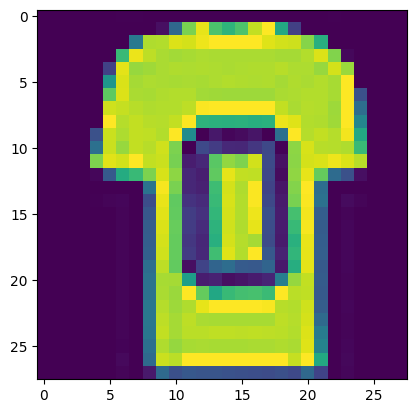

In [ ]:
plt.imshow(Xtr[10].reshape([28,28]))

# Extracting Feature Vectors

In [ ]:
import cv2
import numpy as np
from skimage.feature import hog

def ExtractFeatures_HOG(examples):
    features = []
    for example in examples:
        hog_features = hog(example.reshape((28, 28)))
        features.append(hog_features)
    return features

def ExtractFeatures_SIFT(examples):
    features = []
    sift = cv2.SIFT_create()

    for example in examples:
        example = example.reshape((28, 28)).astype(np.uint8)  # Reshape the example to 28x28 grayscale image
        keypoints, descriptors = sift.detectAndCompute(example, None)
        
        # If keypoints are found, append the descriptors to the features list
        if descriptors is not None:
            features.append(descriptors)

    return features


# Training Model

## Support Vector Classifier

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Extract features from training data
Xtr_features = ExtractFeatures_HOG(Xtr)

# Create SVM model and perform grid search for hyperparameter optimization
svm = SVC()
svm_params = {'C': [1, 10, 100], 'gamma': [0.1, 0.01, 0.001]}
svm_grid = GridSearchCV(svm, svm_params, cv=5)
svm_grid.fit(Xtr_features, Ytr)
best_svm = svm_grid.best_estimator_

In [ ]:
import pickle

# Train final models
final_svm = SVC(C=best_svm.C, gamma=best_svm.gamma)
final_svm.fit(Xtr_features, Ytr)

# Save models to files
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(final_svm, f)

## CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

Xtr_reshaped = Xtr.reshape(-1, 28, 28, 1)
Ytr_tensor = tf.convert_to_tensor(Ytr, dtype=tf.int32)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
model.fit(Xtr_reshaped, Ytr_tensor, batch_size=32, epochs=100, verbose=1)
model.save("cnn_model.h5")

## Naive Bayes

In [ ]:
import numpy as np
import pandas as pd
from sklearn import naive_bayes
from sklearn.model_selection import cross_val_score
import joblib


# Naive Bayes
naive_bayes_clf = naive_bayes.GaussianNB()

# Extract features from training examples
Xtr_features = ExtractFeatures_HOG(Xtr)

# Naive Bayes cross-validation
naive_bayes_clf.fit(Xtr_features, Ytr)
naive_bayes_score = np.mean(cross_val_score(naive_bayes_clf, Xtr_features, Ytr, cv=5))

In [ ]:
# Train the final models
naive_bayes_clf.fit(Xtr_features, Ytr)
joblib.dump(naive_bayes_clf, "NaiveBayes_model.pkl")

['NaiveBayes_model.pkl']

# Make Predictions

In [ ]:
# Load test examples
Xts = np.loadtxt("Dataset/TestData.csv")

# Extract features from test data
Xts_features = ExtractFeatures_HOG(Xts)

## SVM Predictions

In [ ]:
import numpy as np
import pandas as pd
import pickle

# Load trained models
with open('svm_model.pkl', 'rb') as f:
    final_svm = pickle.load(f)

# Generate predictions using the trained models
svm_predictions = final_svm.predict(Xts_features)
print(svm_predictions)
print(type(svm_predictions))

[-1. -1.  1. ...  1. -1. -1.]
<class 'numpy.ndarray'>


## CNN Predictions

In [ ]:
cnn_model = tf.keras.models.load_model("cnn_model.h5")
Xts_reshaped = Xts.reshape(-1, 28, 28, 1)
# cnn_predictions = cnn_model.predict(Xts_reshaped)
cnn_predictions = np.argmax(cnn_model.predict(Xts_reshaped), axis=1)
# cnn_predictions = (cnn_model.predict(Xts_reshaped) > 0.5).astype("int32")
# cnn_predictions = cnn_model.predict_classes(Xts_reshaped)
# np.savetxt("myPredictions.csv", cnn_predictions)
print(cnn_predictions)

63/63 [==============================] - 0s 3ms/step
[0 0 0 ... 0 0 0]


## Naive Bayes Prediction

In [ ]:
# Generate predictions for test examples using Naive Bayes
naive_bayes_predictions = naive_bayes_clf.predict(Xts_features)
# np.savetxt("myPredictions.csv", naive_bayes_predictions, delimiter=",")
print(naive_bayes_predictions)
print(type(naive_bayes_predictions))

[-1. -1. -1. ...  1.  1. -1.]
<class 'numpy.ndarray'>


# Save predictions to a csv

In [ ]:
# Save predictions to CSV file
predictions_df = pd.DataFrame({'SVM': svm_predictions, 'Naive Bayes': naive_bayes_predictions, 'CNN': cnn_predictions})
predictions_df.to_csv('myPredictions.csv', index=False)

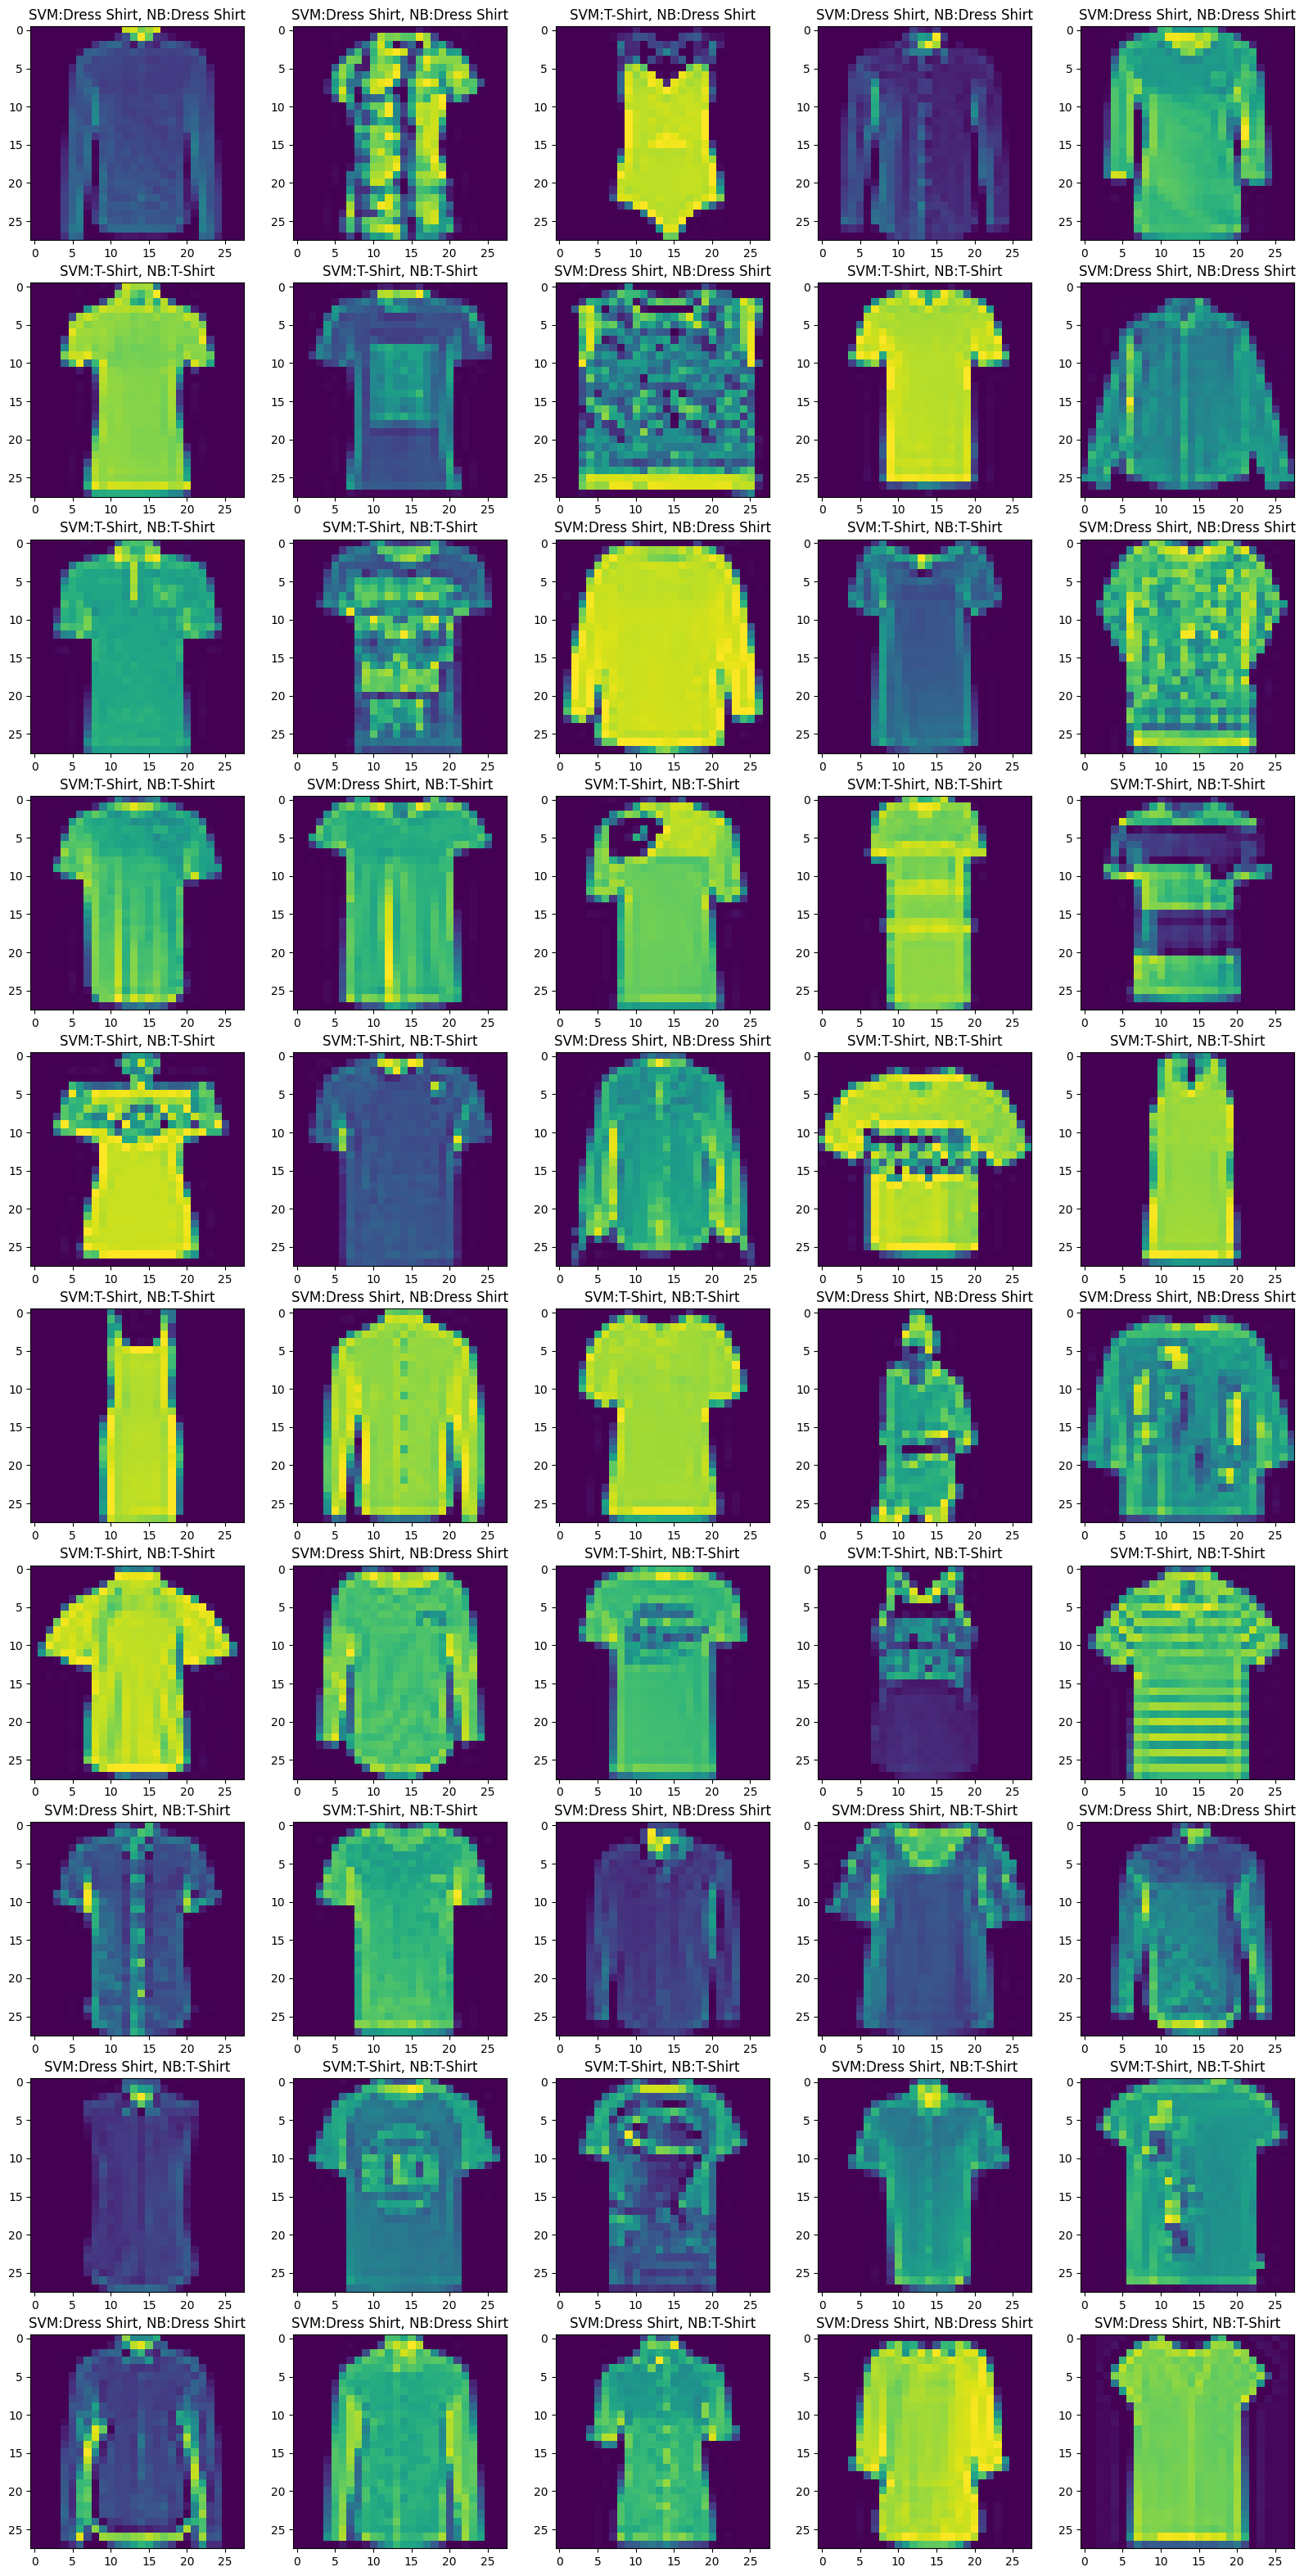

In [ ]:
plt.figure(figsize=(20,40)) # specifying the overall grid size

for i in range(50):
    plt.subplot(10,5,i+1)
    plt.imshow(Xts[i].reshape([28,28]))
    plt.title("SVM:{}, NB:{}".format(
        "Dress Shirt" if svm_predictions[i] == -1.0 else "T-Shirt", 
        "Dress Shirt" if naive_bayes_predictions[i] == -1.0 else "T-Shirt"))

plt.show()


